# Single Cell Biology 
## Mini project : RNA-seq of fly ovaries dataset 

### Gianna Biino, Marianne Scoglio, Gabrielle Blouvac

### Imports 

In [64]:
import scanpy as sc
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt

### Snapshot analysis of the Fly Cell Atlas
#### The Ovaries
This project analyses the dataset of the fly cell atlas, containing the single cell transcriptome of the fly's ovaries.
The goal of this project is to research the cell-types and marker genes found in the ovaries.
The data used has already been preprocessed so we will focus on the downstream analysis.

### Data loading 

In [65]:
data = pd.read_csv('ovary.tsv', sep="\t", index_col=0)
adata = ad.AnnData(data.T)
adata.var_names = data.index  # Gene names
adata.obs_names = data.columns  # Cell names
adata

AnnData object with n_obs × n_vars = 7549 × 11943

##### QC and filtering
In order to analyse the data we perform some quality control and filtering first in order to remove poor quality data.

### Preprocessing 

In [66]:
sc.settings.seed=2

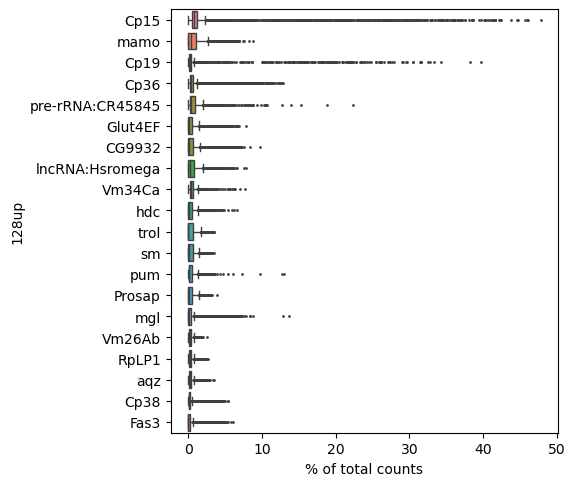

In [67]:
# look at the highest expressed genes
sc.pl.highest_expr_genes(adata, n_top=20)

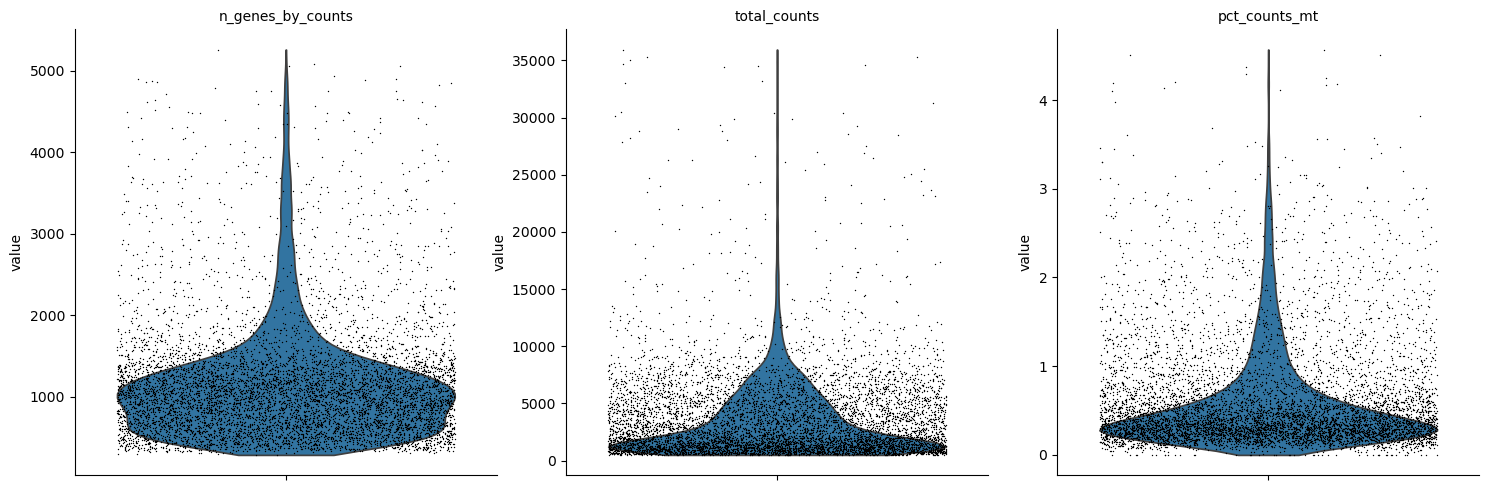

In [68]:
#filter out cells with low gene count and genes that are detected in 3 or less cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# annotate the group of mitochondrial genes as "mt" 
adata.var["mt"] = adata.var_names.str.startswith("mt:")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

# Violin plot to look at the number of genes and cells
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

We observe few cells with a high mitochondrial gene counts, which is great as this means most of the cells are alive and we don't have a lot of dead cells in the sample.

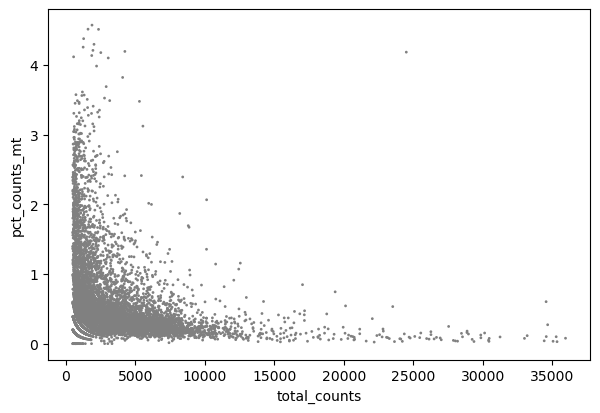

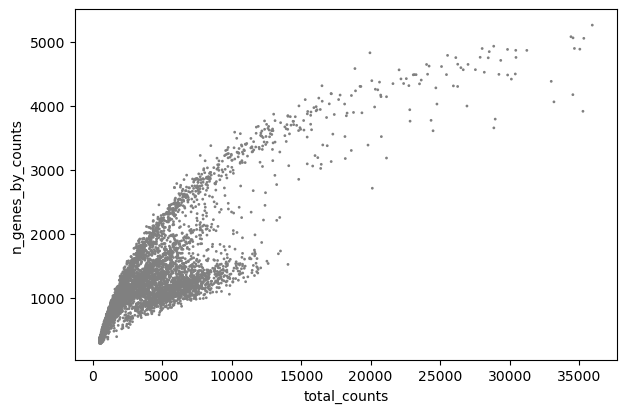

In [69]:
#scatter plots
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

We see that the numbers of mitochondrial genes for each count are below 5 which is quite low, indicating that the cells detected should be healthy. 
We also see that most cells contain a few thousand genes, and there are only some cells that pass over 30'000 genes.
For now we keep the filtering to a minimum and might come back to it

##### Normalization 
In order to be able to compare the gene counts we normalize the data and regress out the effect of the counts per cell and percentage of mitochondrial genes expressed.

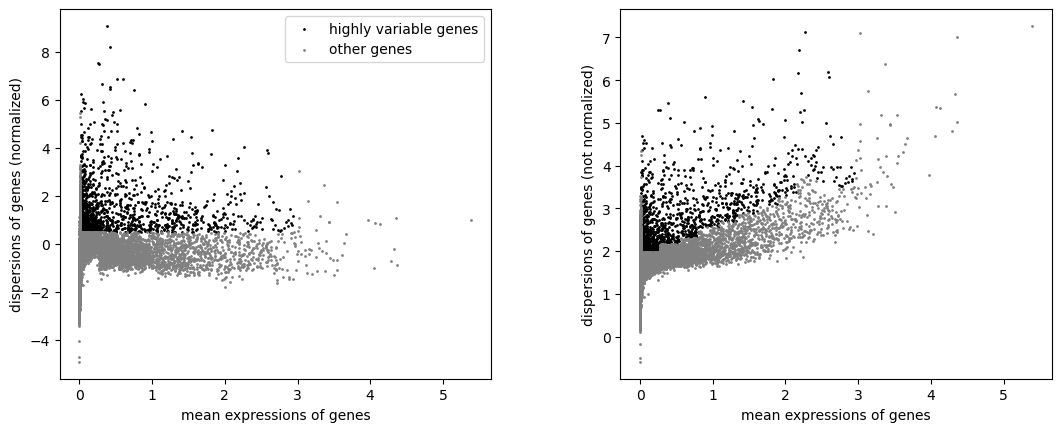

In [70]:
#normalize the total count so that the counts become comparable among cells
sc.pp.normalize_total(adata, target_sum=1e4)
# take the log of the data
sc.pp.log1p(adata)

#look at the highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [71]:
#Set the normalized and logarithmized gene expr for later use to .raw
adata.raw = adata.copy()

#filter 
adata = adata[:, adata.var.highly_variable]
#regress out effects of total count per cell
sc.pp.regress_out(adata, ["total_counts"])
#scale the values
sc.pp.scale(adata, max_value=10)

c:\Users\blouv\anaconda3\envs\scanpy_env\lib\site-packages\scanpy\preprocessing\_simple.py:668: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


We do not regress out the mitochondrial genes as stated above 

##### Principal Component Analysis
We run a PCA on the data in order to analyse the variation in the data

In [72]:
#compute the PCA
sc.tl.pca(adata, svd_solver="arpack")

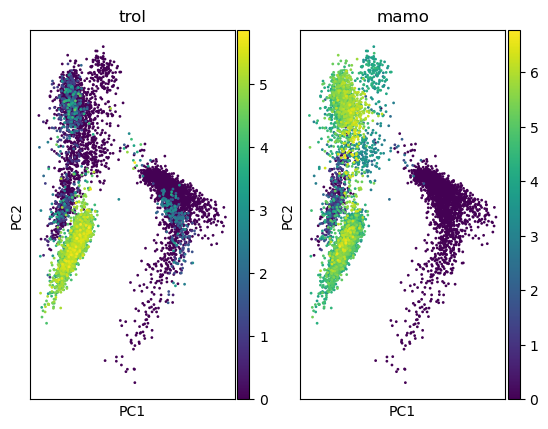

In [80]:
# plot the PCA for the gene Cp15 and mamo
fig, axes = plt.subplots(1,2)
sc.pl.pca(adata, color="trol", ax=axes[0], show=False)
sc.pl.pca(adata, color="mamo", ax=axes[1], show=False)
plt.show()

We see that there is not a big difference of the expression of Cp15 between cells. Mamo however is highly expressed in some cells while not expressed in others.
These two plots only consider the first two principal components though. We have to inspect the contributions of each PC in order to consider as much of the variance as possible.

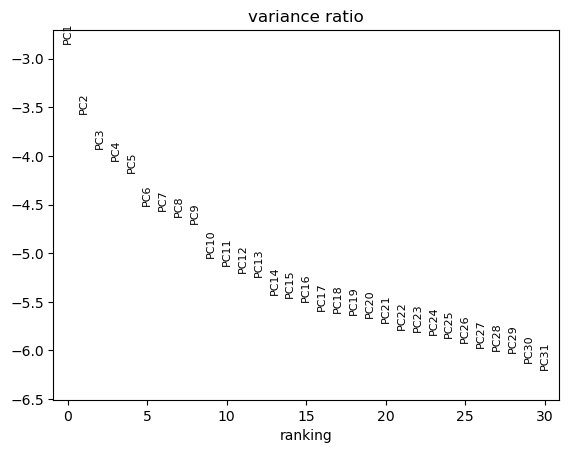

In [74]:
sc.pl.pca_variance_ratio(adata, log=True)

### Computing neighborhood graph 
using PCA representation

In [75]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [76]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    #random_state=0,
    #flavor="igraph",
    #n_iterations=2,
    #directed=False,
)

In [77]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

In [78]:
sc.tl.umap(adata)

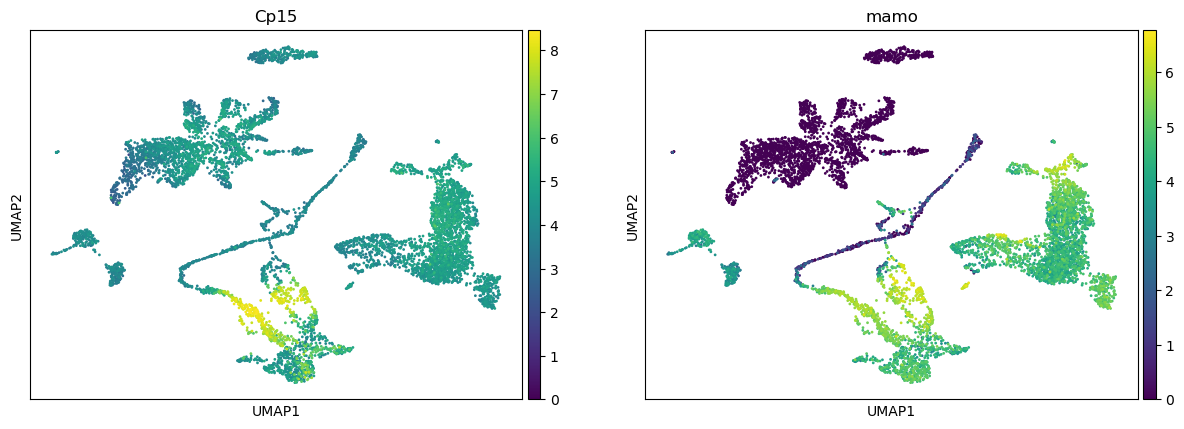

In [79]:
sc.pl.umap(adata, color=["Cp15", "mamo"])